In [2]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import math 
import time
import numpy as np
from collections import Counter
from tqdm import tqdm

filepathTXT = "../edgelists/BlogCatalog-edgelist.txt"
filepathCSV = "../edgelists/BlogCatalog-edgelist.csv"
embeddingsrecursive = "../embeddings/BlogCatalog-edgelist.txt.embeddings-recursive"
embeddingsiterative = "../embeddings/BlogCatalog-edgelist.txt.embeddings-iterative"

In [3]:
def parseEdgeList1(graph_file, delimiter=" ", weighted=False, direction="undirected"):
    if(weighted == False):
        G = nx.read_edgelist(graph_file, delimiter=delimiter)
    else:
        G = nx.read_edgelist(graph_file, delimiter=delimiter, nodetype=int, data=(('weight',float),))
    print(G.number_of_nodes(), G.number_of_edges(), " loaded from ", graph_file)
    if(direction == "undirected"):
        return G.to_undirected()
    else:
        return G

In [4]:
def parseEdgeList2(graph_file, direction="undirected"):
    # Create Graph
    G = nx.Graph()
    # Create head
    colNames=["Start", "End"]
    edgeData = pd.read_csv(filepathCSV, names=colNames)

    #Add nodes
    nodes = []
    #loop throug data records
    for i in range (0, edgeData.shape[0]):
        #append every node
        nodes.append(edgeData.iloc[i,0])
        nodes.append(edgeData.iloc[i,1])
    #creating a set of nodes    
    nodes = set(nodes)
    #sorting the nodes in increasing order
    uniqueNodes = (list(nodes))
    uniqueNodes.sort()
    #adding the nodes to the graph
    G.add_nodes_from(uniqueNodes)

    # Add edges
    #loop from 0 to amount of records
    edgeCount = 0
    for i in range (0, edgeData.shape[0]):
        edgeCount += 1
        #add the edge to the graph
        G.add_edge(edgeData.iloc[i,0], edgeData.iloc[i,1])
    print("Nodes: ", G.number_of_nodes()," Edges: ", G.number_of_edges(), " loaded from ", graph_file)

    if(direction == "undirected"):
        return G.to_undirected()
    else:
        return G

In [5]:
G = parseEdgeList1(filepathTXT) #String labels 
#G = parseEdgeList2(filepathCSV) # Integer labels

10312 333983  loaded from  ../edgelists/BlogCatalog-edgelist.txt


In [6]:
femb_recursive = open(embeddingsrecursive, 'w')
femb_iterative = open(embeddingsiterative, 'w')

## Toy Graph

Nodes:  11  Edges:  20


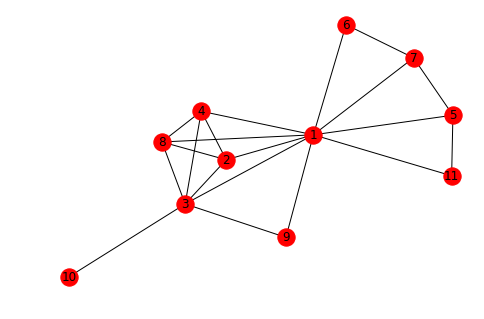

In [59]:
G = nx.Graph()
#Small example
G.add_nodes_from([1,2,3,4,5,6,7,8,9,10,11])
G.add_edge(2, 1);
G.add_edge(3, 1);
G.add_edge(3, 2);
G.add_edge(4, 1);
G.add_edge(4, 2);
G.add_edge(4, 3);
G.add_edge(5, 1);
G.add_edge(6, 1);
G.add_edge(7, 1);
G.add_edge(7, 5);
G.add_edge(7, 6);
G.add_edge(8, 1);
G.add_edge(8, 2);
G.add_edge(8, 3);
G.add_edge(8, 4);                
G.add_edge(9, 1);
G.add_edge(9, 3);
G.add_edge(10, 3);
G.add_edge(11, 1);
G.add_edge(11, 5);

print("Nodes: ", G.number_of_nodes()," Edges: ", G.number_of_edges())
# G.add_nodes_from([1,2,4,5,6,7,9,11])
# G.add_edge(2, 1);
# G.add_edge(4, 1);
# G.add_edge(4, 2);
# G.add_edge(5, 1);
# G.add_edge(6, 1);
# G.add_edge(7, 1);
# G.add_edge(7, 5);
# G.add_edge(7, 6);
# G.add_edge(9, 1);
# G.add_edge(11, 1);
# G.add_edge(11, 5);


# Draw graph
nx.draw(G, with_labels = True)
#plt.show()

## Random Walk with window

In [149]:
def chooseNodes(list_nodes, sample_size):
#     random.seed(0)
    return random.sample(population=list_nodes, k=sample_size) # 2.22 s ± 179 ms per loop  (labesl str)

def getPerNodeBudget(numNodes, budget):
    return math.floor(budget/numNodes)

def storeContextPairs(context_pair, budget, context_pairs):
    if context_pair not in context_pairs:
        context_pairs[context_pair] = budget
    else:
        context_pairs[context_pair] = context_pairs[context_pair] +  budget
        
def updateContextPairs(window, context_pairs, middleNodeId):
    lastNode = window[-1]
    labelOfLastNode, budgetOfLastNode = lastNode
    index_count = 0
    window_except_last = window[:-1]
    for node in reversed(window_except_last):
        node_label = node[0]
        if index_count == ORIGINAL_WINDOW_SIZE:
            break
        context_pair1 = str(labelOfLastNode) +","+ str(node_label)
        context_pair2 = str(node_label) + "," + str(labelOfLastNode)
        storeContextPairs(context_pair1, budgetOfLastNode, context_pairs)
        storeContextPairs(context_pair2, budgetOfLastNode, context_pairs)
        index_count = index_count + 1
    
        
def addNewNodeToWindow(window, vertex, budget):
    window.append([vertex,budget])
    return window

def BFSRandomWalkWindow(graph, start, queue, context_pairs, window_size, walk_lenght, middleNodeIdx):
    while queue:
        vertex, budget, current_walk_lenght, window = queue.pop(0)
        vertex_neighbors = [n for n in G.neighbors(vertex)]
        num_neighbors = len(vertex_neighbors)
        m = getPerNodeBudget(num_neighbors, budget)
        remainder = budget - (m * num_neighbors)
        chosen_nodes = []
        if remainder > 0:
            chosen_nodes = chooseNodes(vertex_neighbors, remainder)
        print(chosen_nodes)
        current_walk_lenght += 1
        for neighbor in vertex_neighbors:
            budget_for_this_node = m 
            if neighbor in chosen_nodes:
                budget_for_this_node = budget_for_this_node + 1
            if(budget_for_this_node > 0):
                if len(window) == window_size:
                    window.pop(0)
                addNewNodeToWindow(window, neighbor, budget_for_this_node) 
                print(window)
                updateContextPairs(window, context_pairs, middleNodeIdx) 
                if current_walk_lenght < walk_lenght:
                    queue.append((neighbor, budget_for_this_node, current_walk_lenght, list(window)))
                window.pop(-1)
        print(context_pairs)

### Actual case

In [150]:
def Runner():
    context_pairs = {}
    
#     # Set the actual parameters 
#     WALK_LENGHT = 40
#     BUDGET = 80
#     WINDOW_SIZE = 10
#     WINDOW_SIZE = WINDOW_SIZE*2+1
#     WINDOW=[]
    
    # Set toy parameters     
    WINDOW_SIZE = ORIGINAL_WINDOW_SIZE*2+1
    MIDDLE_NODE = math.floor(WINDOW_SIZE/2)
    WINDOW=[]
#     nodedegree = sorted(G.degree, key=lambda x: x[1], reverse=True)
#     nodes = [n[0] for n in nodedegree]
#     nodes = [n for n in G.nodes()]
#     rand.shuffle(nodes)
    nodes = list(G.nodes)
    print("Running BFSRandomWalkWindow...")
    for startvertex in nodes:
        print(startvertex)
        WINDOW = [[startvertex, BUDGET]]
        queue = [(startvertex, BUDGET, 1, WINDOW)]
        BFSRandomWalkWindow(G, startvertex, queue, context_pairs, WINDOW_SIZE, WALK_LENGHT, MIDDLE_NODE)
#         break
    return context_pairs


In [151]:
#%timeit Runner()

In [152]:
random.seed(0)
rand=random.Random(0)
WALK_LENGHT = 3
BUDGET = 1
ORIGINAL_WINDOW_SIZE = 1
contextPairs = Runner()
print(contextPairs)

Running BFSRandomWalkWindow...
1
[8]
[[1, 1], [8, 1]]
{'8,1': 1, '1,8': 1}
[4]
[[1, 1], [8, 1], [4, 1]]
{'8,1': 1, '1,8': 1, '4,8': 1, '8,4': 1}
2
[1]
[[2, 1], [1, 1]]
{'8,1': 1, '1,8': 1, '4,8': 1, '8,4': 1, '1,2': 1, '2,1': 1}
[6]
[[2, 1], [1, 1], [6, 1]]
{'8,1': 1, '1,8': 1, '4,8': 1, '8,4': 1, '1,2': 1, '2,1': 1, '6,1': 1, '1,6': 1}
3
[9]
[[3, 1], [9, 1]]
{'8,1': 1, '1,8': 1, '4,8': 1, '8,4': 1, '1,2': 1, '2,1': 1, '6,1': 1, '1,6': 1, '9,3': 1, '3,9': 1}
[3]
[[3, 1], [9, 1], [3, 1]]
{'8,1': 1, '1,8': 1, '4,8': 1, '8,4': 1, '1,2': 1, '2,1': 1, '6,1': 1, '1,6': 1, '9,3': 2, '3,9': 2}
4
[8]
[[4, 1], [8, 1]]
{'8,1': 1, '1,8': 1, '4,8': 2, '8,4': 2, '1,2': 1, '2,1': 1, '6,1': 1, '1,6': 1, '9,3': 2, '3,9': 2}
[3]
[[4, 1], [8, 1], [3, 1]]
{'8,1': 1, '1,8': 1, '4,8': 2, '8,4': 2, '1,2': 1, '2,1': 1, '6,1': 1, '1,6': 1, '9,3': 2, '3,9': 2, '3,8': 1, '8,3': 1}
5
[7]
[[5, 1], [7, 1]]
{'8,1': 1, '1,8': 1, '4,8': 2, '8,4': 2, '1,2': 1, '2,1': 1, '6,1': 1, '1,6': 1, '9,3': 2, '3,9': 2, '3,8': 1,

In [153]:
contextPairs

{'8,1': 1,
 '1,8': 1,
 '4,8': 2,
 '8,4': 2,
 '1,2': 2,
 '2,1': 2,
 '6,1': 4,
 '1,6': 4,
 '9,3': 4,
 '3,9': 4,
 '3,8': 1,
 '8,3': 1,
 '7,5': 2,
 '5,7': 2,
 '11,1': 2,
 '1,11': 2,
 '1,7': 1,
 '7,1': 1,
 '2,8': 1,
 '8,2': 1,
 '3,10': 2,
 '10,3': 2}

### Writing to file

In [95]:
print("Writing context pairs to file...")    
#Writing to file    
for (key, value) in contextPairs.items():
    
    femb_iterative.write(str(key) + " " + str(value) + "\n" )
femb_iterative.close()

Writing context pairs to file...
